### 1. Dependencias y Configuración Entorno

In [2]:
# 1.1 Librerías Principales
import numpy as np
import pandas as pd

# 1.2 Librerías Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# 1.3 Otras Librerías
from functools import reduce

# 1.4 Customization del NoteBook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1.5 Direccionamiento Paths
pathRoot  = "./DatosProyecto/"
pathCSV   = pathRoot + "bank-additional.csv"
pathExcel = pathRoot + "customer-details.xlsx"

### 2. Definición de Funciones

In [3]:
# 2.1 Función `extraerElementoFecha(fecha, elemento)` 
def extraerElementoFecha(fecha, elemento):
    """
    A partir de a) y b), devolvemos el elemento que se busca en formato String.:  
        a) Una fecha en string con formato 'dd-mm-yyyy' 
        b) Un elemento 'd', 'm' o 'y'    
    Ej: extraerElementoFecha("19-Noviembre-2025", "d") -> "19"  
    Ej: extraerElementoFecha("19-Noviembre-2025", "m") -> "Noviembre"  
    Ej: extraerElementoFecha("19-Noviembre-2025", "y") -> "2025"  
    """
    if isinstance(fecha, str) and isinstance(elemento, str):
        try:
            day, month, year = fecha.split("-")
            if elemento.lower()=="d":
                return day
            elif elemento.lower() == "m":
                if month.lower()=='enero':
                    month = 1
                elif month.lower()=='febrero':
                    month = 2
                elif month.lower()=='marzo':
                    month = 3
                elif month.lower()=='abril':
                    month = 4
                elif month.lower()=='mayo':
                    month = 5
                elif month.lower()=='junio':
                    month = 6
                elif month.lower()=='julio':
                    month = 7
                elif month.lower()=='agosto':
                    month = 8
                elif month.lower()=='septiembre':
                    month = 9
                elif month.lower()=='octubre':
                    month = 10
                elif month.lower()=='noviembre':
                    month = 11
                elif month.lower()=='diciembre':
                    month = 12
                return (int)(month)
            elif elemento.lower() == "y":
                return year
        except ValueError:
            raise ValueError("Algun valor no es correcto, el elemento debe ser 'd', 'm' o 'y', y la fecha correcta 'd-m-y'.")
    else:
        return None

### 3. Procesamiento de Archivos

#### 3.1. Preparación Inicial `.XLSX`

In [4]:
# 3.1.1 Identificación Hojas  
hojasExcel = pd.ExcelFile(pathExcel)

# Introducimos todas las hojas en una lista
contenedorHojas = []
for hoja in hojasExcel.sheet_names:
    contenedorHojas.append(pd.read_excel(pathExcel, sheet_name = hoja)) 

# 3.1.2 Comprobación Columnas entre Hojas
columnasOk = True
for i in range(len(contenedorHojas)-1):
    if not contenedorHojas[i].columns.equals(contenedorHojas[i+1].columns):
        columnasOk = False

# 3.1.3 Concatenación Hojas en DataFrame `df1` y Check Dimensiones
if columnasOk:
    df1 = pd.concat(contenedorHojas, ignore_index=True)
else:
    print("Las columnas entre las hojas no coinciden, por lo que no se procede a la unión del documento.")

#### 3.2. Preparación Inicial `.CSV`

In [5]:
# 3.2.1 Transformación en DataFrame `df2` y Check Dimensiones  
df2 = pd.read_csv(pathCSV)

### 3.3. Preparación para Unificar DataFrames con `.Merge()`

In [6]:
# 3.3.1 Identificación Columnas en `df1` y `df2`  
print(list(df1.columns))
print(list(df2.columns))

['Unnamed: 0', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'NumWebVisitsMonth', 'ID']
['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id_']


In [7]:
# 3.3.2 Comprobación Duplicados en `df1` y `df2`
temp = df1.drop(columns=["ID","Unnamed: 0"])
print(f"Elementos duplicados: {temp.duplicated().sum()}")

temp = df2.drop(columns=["id_","Unnamed: 0"])
print(f"Elementos duplicados: {temp.duplicated().sum()}")

Elementos duplicados: 0
Elementos duplicados: 0


In [8]:
# 3.3.3 Corrección Columnas en DataFrames

# He visto columnas incorrectas, por ejemplo:
#   - Columna "Unnamed: 0", se le cambia el nombre por position
#   - Columna "ID" e "id_": se cambian por un valor común, es la columna que usaré para casar ambas tablas
df1.rename(columns={"ID" : "id", "Unnamed: 0": "position"}, inplace=True)
df2.rename(columns={"id_": "id", "Unnamed: 0": "position"}, inplace=True)

# Aprovecho para poner en minúsculas y sin espacios prev/post a todas las columnas y evitar así problemas case sensitive
df1.columns = df1.columns.str.lower().str.strip()
df2.columns = df2.columns.str.lower().str.strip()

print(f"Las columnas del DataFrame1 son: {list(df1.columns)}")
print(f"Las columnas del DataFrame2 son: {list(df2.columns)}")

Las columnas del DataFrame1 son: ['position', 'income', 'kidhome', 'teenhome', 'dt_customer', 'numwebvisitsmonth', 'id']
Las columnas del DataFrame2 son: ['position', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id']


In [10]:
# 3.3.4 Creación Columnas `contact_month` y `contact_year`

# Busco posición columna "date" e información sobre ella
print(f"""La columna 'date' está en la posición: {df2.columns.get_loc("date")}
Los datos dentro de la columna 'date' son de tipo {type(df2["date"][1])} y tiene el siguiente formato: {df2["date"][1]}.
""")

# Añado las nuevas columnas, utilizo función lambda para aplicar a cada línea de la DataFrame la función `extraerElementosFecha(fecha, elemento)`
df2.insert(21, "contact_day", df2["date"].apply(lambda x: extraerElementoFecha(x, 'd')))
df2.insert(22, "contact_month", df2["date"].apply(lambda x: extraerElementoFecha(x, 'm')))
df2.insert(23, "contact_year",  df2["date"].apply(lambda x: extraerElementoFecha(x, 'y')))

# Reviso que las columnas estén correctamente creadas
print(f"""La columna 'contact_day' está ubicada en la posición {df2.columns.get_loc("contact_day")}
La columna 'contact_month' está ubicada en la posición {df2.columns.get_loc("contact_month")}
La columna 'contact_year'  está ubicada en la posición {df2.columns.get_loc("contact_year")}""")

La columna 'date' está en la posición: 20
Los datos dentro de la columna 'date' son de tipo <class 'str'> y tiene el siguiente formato: 14-septiembre-2016.

La columna 'contact_day' está ubicada en la posición 21
La columna 'contact_month' está ubicada en la posición 22
La columna 'contact_year'  está ubicada en la posición 23


In [12]:
# 3.3.5 Comprobación Dimensiones Tablas

# Antes de hacer el merge, compruebo la longitud de ambas tablas
print(df1.shape)
print(df2.shape)

(43170, 7)
(43000, 27)


In [157]:
# 3.3.6 Unión de DataFrames

# He observado que las dimensiones de los dos archivos difieren, los datos
# más importantes están en el df2. Por lo que vamos a realizar un conexionado "inner"
# para enlazar solo aquellos datos que estén relacionados entre sí.
df = pd.merge(df2, df1, on="id", how="inner")

print(df.shape)
df.head(0)

(43000, 33)


,position_x,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,contact_day,contact_month,contact_year,latitude,longitude,id,position_y,income,kidhome,teenhome,dt_customer,numwebvisitsmonth


In [158]:
# Al unir las dos tablas, se han creado dos índices. Eliminamos el indice que no nos interesa y renombramos el otro.
df.drop(columns=['position_y'], inplace=True)
df.rename(columns={"position_x": "position"}, inplace=True)

print(df.shape)
df.head(0)

(43000, 32)


,position,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,contact_day,contact_month,contact_year,latitude,longitude,id,income,kidhome,teenhome,dt_customer,numwebvisitsmonth


### 3.4. Limpieza de Datos

In [159]:
# 3.4.1 Comprobación Columnas (NaN, Tipo Dato)  

dfNanValues = []
dfTypes = []
for i in list(df.columns):
    dfNanValues.append((int)(df[i].isna().sum()))
    dfTypes.append(df[i].dtypes)

tablaNaN = pd.DataFrame({
    "Valor": list(df.columns),
    "Número": dfNanValues,
    "Tipo Dato": dfTypes
})
tablaNaN

,Valor,Número,Tipo Dato
0,position,0,int64
1,age,5120,float64
2,job,345,object
3,marital,85,object
4,education,1807,object
5,default,8981,float64
6,housing,1026,float64
7,loan,1026,float64
8,contact,0,object
9,duration,0,int64


In [182]:
# 3.4.2 Creación Copia antes de Limpieza Datos
dfNew = df.copy()

In [ ]:
# 3.4.3  Corrección Tipos de Dato

# Corregimos los valores de `cons.conf.idx`
if dfNew['cons.conf.idx'].dtype.kind != 'f':
    dfNew['cons.conf.idx'] = (dfNew['cons.conf.idx'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `cons.price.idx`
if dfNew['cons.price.idx'].dtype.kind != 'f':
    dfNew['cons.price.idx'] = (dfNew['cons.price.idx'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `euribor3m`
if dfNew['euribor3m'].dtype.kind != 'f':
    dfNew['euribor3m'] = (dfNew['euribor3m'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `age`
if dfNew['age'].dtype.kind != 'i':
    dfNew['age'] = (dfNew['age'].astype('Int64'))


# Corregimos los valores de `default`
if dfNew['default'].dtype.kind != 'i':
    dfNew['default'] = (dfNew['default'].astype('Int64'))


# Corregimos los valores de `housing`
if dfNew['housing'].dtype.kind != 'i':
    dfNew['housing'] = (dfNew['housing'].astype('Int64'))
    

# Corregimos los valores de `loan`
if dfNew['loan'].dtype.kind != 'i':
    dfNew['loan'] = (dfNew['loan'].astype('Int64'))


# Corregimos los valores de `nr.employed`
if dfNew['nr.employed'].dtype.kind != 'f':
    dfNew['nr.employed'] = (dfNew['nr.employed'].str.replace(',', '.', regex=False).astype(float))




##########      Date    ##########

# Corregimos los valores de `contact_day`
if dfNew['contact_day'].dtype.kind != 'i':
    dfNew['contact_day'] = (dfNew['contact_day'].astype('Int64'))

# Corregimos los valores de `contact_month`
if dfNew['contact_month'].dtype.kind != 'i':
    dfNew['contact_month'] = (dfNew['contact_month'].astype('Int64'))

# Corregimos los valores de `contact_year`
if dfNew['contact_year'].dtype.kind != 'i':
    dfNew['contact_year'] = (dfNew['contact_year'].astype('Int64'))




# Ahora que tengo los datos corregidos del día de contacto, pasamos a reconstruir date con un formato DateTime
mask = dfNew[['contact_year', 'contact_month', 'contact_day']].notna().all(axis=1)

# Construimos un string 'YYYY-MM-DD' solo para esas filas
fecha_str = (
    dfNew.loc[mask, 'contact_year'].astype('int').astype(str) + '-' +
    dfNew.loc[mask, 'contact_month'].astype('int').astype(str).str.zfill(2) + '-' +
    dfNew.loc[mask, 'contact_day'].astype('int').astype(str).str.zfill(2)
)

dfNew.loc[mask, 'date'] = pd.to_datetime(fecha_str, errors='coerce').dt.date
dfNew['dt_customer'] = pd.to_datetime(dfNew['dt_customer'], errors='coerce').dt.date


In [184]:
# 3.4.4  Relleno Huecos Vacíos

# Para los datos de edad, vamos a darle un valor 0 a los vacíos. Siendo este dato, un dato desconocido
dfNew['age'] = dfNew['age'].fillna(0)

# Los datos 'default', 'housing' y 'loan' vamos a darle un valor 2 a los vacíos. 0: No, 1: Sí, 2: Desconocido
dfNew['default'] = dfNew['default'].fillna(2)
dfNew['housing'] = dfNew['housing'].fillna(2)
dfNew['loan']    = dfNew['loan'].fillna(2)

# Los datos 'Job', 'marital' y 'education', vamos a darle un valor unknown.
dfNew['job']       = dfNew['job'].fillna("unknown")
dfNew['marital']   = dfNew['marital'].fillna('unknown')
dfNew['education'] = dfNew['education'].fillna('unknown')

In [189]:
# 3.4.4  Busqueda correlación entre `euribor3m` y `emp.var.rate`
dfNew[['emp.var.rate', 'euribor3m']].corr()

# He visto una fuerte relación entre un conjunto de datos 'emp.var.rate','cons.price.idx`, `cons.conf.idx` y `euribor3m`
# Es por ello que voy a proceder, en relación a estos datos a rellenar los 9256 valores NaN del euribor con su anterior y posterior si estos datos son correctos.
dfNew['euribor3m'] = (
    dfNew.groupby(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx'])['euribor3m']
         .transform(lambda x: x.ffill().bfill())
)

# Ahora que solo faltan 471 datos de `euribor3m` y `cons.price.idx`, voy a proceder a rellenarlos según su anterior y posterior.
# Es decir, primero hemos hecho un relleno más controlado y seguro, y ahora vamos a proceder a rellenar los pocos datos faltantes.

dfNew['euribor3m'] = dfNew['euribor3m'].ffill().bfill()
dfNew['cons.price.idx'] = dfNew['cons.price.idx'].ffill().bfill()


### 3.5 Exportación Datos a Excel

In [ ]:
dfNew.to_excel(r'C:\Users\dmeco\Documents\GitHub\Master-2-Proyecto-3-EDA\DatosProyecto\tabla_limpia.xlsx', index=False)

### 4. Analisis de Datos 

##### 4.1. Clientes Suscritos

In [120]:
# Calculamos la cantidad de clientes suscritos
dfNew['y'].value_counts()

clientesSuscritos = df[df["y"]=="yes"]

# Segundo: Miramos de los clientes suscritos, cuales aportan edad y cuales no.
print(f"Clientes suscritos con registros de edad = {clientesSuscritos["age"].count()}")
print(f"Clientes suscritos sin registros de edad = {clientesSuscritos["age"].isnull().sum()}\n")

Clientes suscritos con registros de edad = 4266
Clientes suscritos sin registros de edad = 578



In [121]:
# 4.1.1. Clasificación por Edad
clientesSuscritosConEdad = clientesSuscritos[clientesSuscritos["age"]>0]

print(f"Cliente más Joven: {  (int)(clientesSuscritosConEdad["age"].min())}")    #17 años
print(f"Cliente más Mayor: {  (int)(clientesSuscritosConEdad["age"].max())}\n")  #98 años
print(f"Edad media: {         round(clientesSuscritosConEdad["age"].mean(),2)}") #40.88 años
print(f"Desviación Estandar: {round(clientesSuscritosConEdad["age"].std(),2)}")  #13.82 años
print(f"Varianza: {           round(clientesSuscritosConEdad["age"].var(),2)}")  #191.091

Cliente más Joven: 17
Cliente más Mayor: 98

Edad media: 40.89
Desviación Estandar: 13.82
Varianza: 191.09


##### 4.1.2. Cálculo Clientes Contactados Vs Suscritos

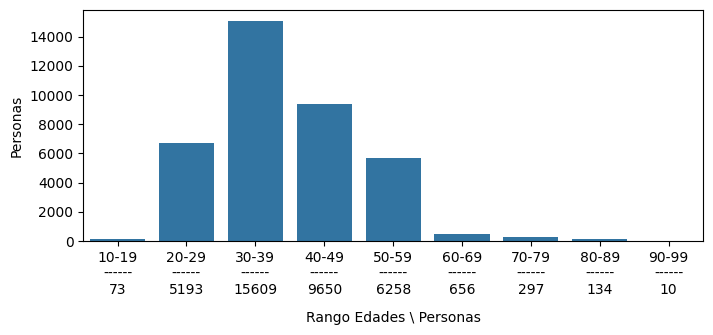

In [122]:
# 4.1.2.1. Gráfica Clientes Contactados

franjaEdades = range(10, 101, 10)  # 10-19, 20-29, ..., 90-99

etiquetas = []
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}\n------\n{df[df['age'].between(i,i+9)]['id'].count()}")

conteos_suscritos = pd.cut(df["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

plt.figure(figsize=(8,3))
sns.barplot(x=conteos_suscritos.index, y=conteos_suscritos.values)
plt.ylabel("Personas")
plt.xlabel(f"Rango Edades \\ Personas", labelpad=10.0, loc="center")
plt.xticks(rotation=0)
plt.show()


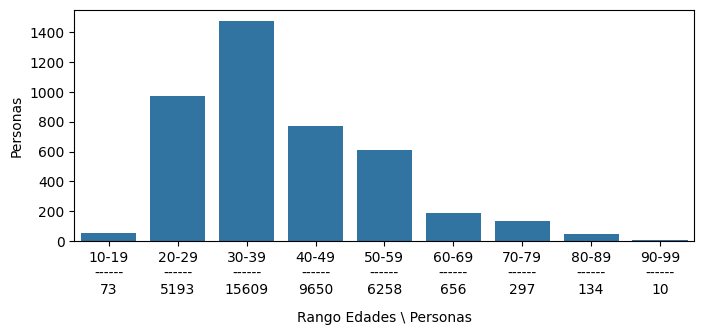

In [123]:
# 4.1.2.2. Gráfica Clientes Suscritos

conteos_total = pd.cut(clientesSuscritos["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

plt.figure(figsize=(8,3))
sns.barplot(x=conteos_total.index, y=conteos_total.values)
plt.ylabel("Personas")
plt.xlabel(f"Rango Edades \\ Personas", labelpad=10.0, loc="center")
plt.xticks(rotation=0)
plt.show()

In [124]:
# 4.1.2.3. Cálculo % de Contratación por Edad

# Duplico todo esto para que tenga sentido la tabla inferior
etiquetas = []
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}")

conteos_suscritos = pd.cut(clientesSuscritos["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()
conteos_total = pd.cut(df["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

# Necesito ver 9 filas
pd.set_option('display.max_rows', 9)

# % Conversión
conversion = ((conteos_suscritos / conteos_total) * 100).round(2)

# Tabla resumen
edad_stats = pd.DataFrame({"Contactados": conteos_total, "Suscritos": conteos_suscritos, "% Suscripción": conversion})
edad_stats

,Contactados,Suscritos,% Suscripción
age,,,
10-19,136,55,40.44
20-29,6735,973,14.45
30-39,15071,1477,9.80
40-49,9378,771,8.22
50-59,5714,611,10.69
60-69,445,191,42.92
70-79,288,136,47.22
80-89,103,47,45.63
90-99,10,5,50.00


In [53]:
# 4.1.2.3. Cálculo % de Contratación por Fecha

# Totales por mes
contactados_mes = df.groupby(["contact_year", "contact_month"])["id"].count()

# Suscritos por mes
suscritos_mes = clientesSuscritosConEdad.groupby(["contact_year", "contact_month"])["id"].count()

# % Conversión
conversion_mes = (suscritos_mes / contactados_mes * 100).round(2)

pd.set_option('display.max_rows', 60)
# Tabla resumen
tabla_mes = pd.DataFrame({
    "Contactados": contactados_mes,
    "Suscritos": suscritos_mes,
    "% Conversión": conversion_mes
}).fillna(0)  # por si hay meses sin suscritos

tabla_mes.sort_index()

Contactados  Suscritos  % Conversión
contact_year contact_month                                      
2015         1.0                    706         71         10.06
             2.0                    709         74         10.44
             3.0                    766         67          8.75
             4.0                    719         53          7.37
             5.0                    715         76         10.63
             6.0                    700         60          8.57
             7.0                    713         60          8.42
             8.0                    674         78         11.57
             9.0                    713         74         10.38
             10.0                   712         75         10.53
             11.0                   701         70          9.99
             12.0                   716         67          9.36
2016         1.0                    711         83         11.67
             2.0                    701         63          8.99
             3.0                    726         66          9.09
             4.0                    696         69          9.91
             5.0                    692         60          8.67
             6.0                    734         91         12.40
             7.0                    699         72         10.30
             8.0                    706         71         10.06
             9.0                    727         69          9.49
             10.0                   735         87         11.84
             11.0                   704         65          9.23
             12.0                   702         74         10.54
2017         1.0                    716         66          9.22
             2.0                    712         67          9.41
             3.0                    701         71         10.13
             4.0                    701         75         10.70
             5.0                    716         57          7.96
             6.0                    686         72         10.50
             7.0                    689         60          8.71
             8.0                    743         70          9.42
             9.0                    735         58          7.89
             10.0                   742         84         11.32
             11.0                   714         79         11.06
             12.0                   707         70          9.90
2018         1.0                    677         55          8.12
             2.0                    714         69          9.66
             3.0                    675         67          9.93
             4.0                    782         83         10.61
             5.0                    723         67          9.27
             6.0                    725         79         10.90
             7.0                    729         86         11.80
             8.0                    693         73         10.53
             9.0                    685         59          8.61
             10.0                   701         68          9.70
             11.0                   759         85         11.20
             12.0                   686         66          9.62
2019         1.0                    707         79         11.17
             2.0                    741         78         10.53
             3.0                    721         68          9.43
             4.0                    684         70         10.23
             5.0                    701         71         10.13
             6.0                    693         49          7.07
             7.0                    763         80         10.48
             8.0                    710         76         10.70
             9.0                    709         65          9.17
             10.0                   709         70          9.87
             11.0                   725         75         10.34
             12.0                   701         75         10.7